C:\Users\devia\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\devia\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\devia\AppData\Local\Temp\ipykernel_23860\3354600938.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
C:\Users\devia\AppData\Roaming\Python\Python313\site-packages\torch\amp\grad_scaler.py:136: UserWarning: torch.cuda.

[Head] Epoch 1/10 Train Acc=0.8058 Val Acc=0.8742
[Head] Epoch 2/10 Train Acc=0.8549 Val Acc=0.8981
[Head] Epoch 3/10 Train Acc=0.8679 Val Acc=0.8822
[Head] Epoch 4/10 Train Acc=0.8679 Val Acc=0.9045
[Head] Epoch 5/10 Train Acc=0.8816 Val Acc=0.9045
[Head] Epoch 6/10 Train Acc=0.8877 Val Acc=0.9045
[Head] Epoch 7/10 Train Acc=0.8778 Val Acc=0.9140
[Head] Epoch 8/10 Train Acc=0.8867 Val Acc=0.8949
[Head] Epoch 9/10 Train Acc=0.8819 Val Acc=0.9236
[Head] Epoch 10/10 Train Acc=0.8911 Val Acc=0.9156


C:\Users\devia\AppData\Local\Temp\ipykernel_23860\3354600938.py:115: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Fine] Epoch 1/10 Train Acc=0.8785 Val Acc=0.9220
[Fine] Epoch 2/10 Train Acc=0.8928 Val Acc=0.8965
[Fine] Epoch 3/10 Train Acc=0.9041 Val Acc=0.9156
[Fine] Epoch 4/10 Train Acc=0.9106 Val Acc=0.9395
[Fine] Epoch 5/10 Train Acc=0.9160 Val Acc=0.9013
[Fine] Epoch 6/10 Train Acc=0.9157 Val Acc=0.9315
[Fine] Epoch 7/10 Train Acc=0.9280 Val Acc=0.9490
[Fine] Epoch 8/10 Train Acc=0.9276 Val Acc=0.9443
[Fine] Epoch 9/10 Train Acc=0.9242 Val Acc=0.9459
[Fine] Epoch 10/10 Train Acc=0.9239 Val Acc=0.9331
Best val acc: 0.9490445859872612


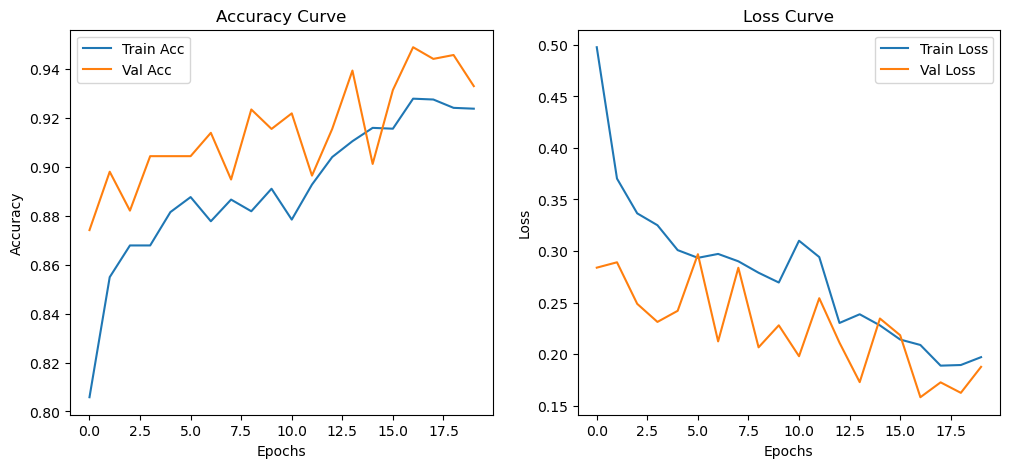


===== Final Evaluation Metrics =====
Accuracy     : 0.9490
Precision    : 0.9484
Recall       : 0.9191
F1-score     : 0.9295
Specificity  : 0.9827
MSE          : 0.1704
Log Loss     : 0.1582
AUC-ROC      : 0.9940

===== Classification Report =====
                precision    recall  f1-score   support

        Blight       0.87      0.97      0.92       172
   Common_Rust       0.98      0.98      0.98       196
Gray_Leaf_Spot       0.94      0.72      0.82        86
       Healthy       1.00      1.00      1.00       174

      accuracy                           0.95       628
     macro avg       0.95      0.92      0.93       628
  weighted avg       0.95      0.95      0.95       628



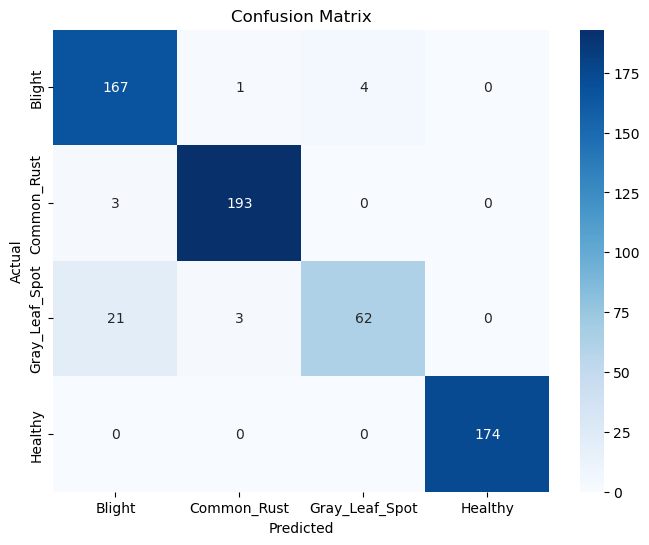

In [1]:
# =========================
# AlexNet for Maize Leaf Detection (Already Split Dataset)
# =========================
import os, time
import torch, torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import models, datasets, transforms as T
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, mean_squared_error, log_loss, roc_auc_score,
    classification_report
)
import numpy as np

# ========= Dataset Path =========
DATA_DIR = r"D:\maize_project\Dataset"   # already has train/val
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR   = os.path.join(DATA_DIR, "val")

# ========= Parameters =========
NUM_CLASSES = len(os.listdir(TRAIN_DIR))
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS_HEAD = 10
EPOCHS_FINE = 10
PATIENCE = 5
SAVE_PATH = "alexnet_maize.pth"

# ========= Transforms =========
train_tf = T.Compose([
    T.RandomResizedCrop(224),
    T.RandomHorizontalFlip(),
    T.RandomRotation(20),
    T.ColorJitter(brightness=0.2, contrast=0.15, saturation=0.15),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
val_tf = T.Compose([
    T.Resize(256), T.CenterCrop(224), T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# ========= Load Dataset =========
train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_tf)
val_ds   = datasets.ImageFolder(VAL_DIR, transform=val_tf)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# ========= Model =========
model = models.alexnet(pretrained=True)
in_f = model.classifier[6].in_features
model.classifier[6] = nn.Linear(in_f, NUM_CLASSES)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-4)
scaler = GradScaler()

# ========= Evaluation =========
def evaluate(net, loader):
    net.eval(); correct=total=loss_sum=0
    with torch.no_grad():
        for xb,yb in loader:
            xb,yb = xb.to(DEVICE), yb.to(DEVICE)
            out = net(xb)
            loss = criterion(out,yb).item()
            _,pred = out.max(1)
            correct += (pred==yb).sum().item(); total += yb.size(0)
            loss_sum += loss * yb.size(0)
    return correct/total, loss_sum/total

# ========= Training =========
train_acc_history, val_acc_history = [], []
train_loss_history, val_loss_history = [], []

# Step 1: Freeze backbone, train FC head
for p in model.features.parameters(): p.requires_grad=False
for p in model.classifier[6].parameters(): p.requires_grad=True

best = 0.0; patience_counter=0
for epoch in range(EPOCHS_HEAD):
    model.train(); running_loss=0; correct=0; total=0
    for xb,yb in train_loader:
        xb,yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        with autocast():
            out = model(xb); loss = criterion(out,yb)
        scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
        running_loss += loss.item() * yb.size(0)
        _,pred = out.max(1); correct += (pred==yb).sum().item(); total += yb.size(0)
    train_acc = correct/total; train_loss = running_loss/total
    val_acc, val_loss = evaluate(model, val_loader)
    train_acc_history.append(train_acc); val_acc_history.append(val_acc)
    train_loss_history.append(train_loss); val_loss_history.append(val_loss)
    print(f"[Head] Epoch {epoch+1}/{EPOCHS_HEAD} Train Acc={train_acc:.4f} Val Acc={val_acc:.4f}")
    if val_acc>best:
        best=val_acc; patience_counter=0; torch.save(model.state_dict(), SAVE_PATH)
    else:
        patience_counter+=1
        if patience_counter>=PATIENCE: break

# Step 2: Fine-tune all layers
for p in model.parameters(): p.requires_grad=True
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

for epoch in range(EPOCHS_FINE):
    model.train(); running_loss=0; correct=0; total=0
    for xb,yb in train_loader:
        xb,yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        with autocast():
            out = model(xb); loss = criterion(out,yb)
        scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
        running_loss += loss.item() * yb.size(0)
        _,pred = out.max(1); correct += (pred==yb).sum().item(); total += yb.size(0)
    train_acc = correct/total; train_loss = running_loss/total
    val_acc, val_loss = evaluate(model, val_loader)
    train_acc_history.append(train_acc); val_acc_history.append(val_acc)
    train_loss_history.append(train_loss); val_loss_history.append(val_loss)
    print(f"[Fine] Epoch {epoch+1}/{EPOCHS_FINE} Train Acc={train_acc:.4f} Val Acc={val_acc:.4f}")
    if val_acc>best:
        best=val_acc; patience_counter=0; torch.save(model.state_dict(), SAVE_PATH)
    else:
        patience_counter+=1
        if patience_counter>=PATIENCE: break

print("Best val acc:", best)

# ========= Plot Curves =========
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_acc_history, label='Train Acc')
plt.plot(val_acc_history, label='Val Acc')
plt.xlabel("Epochs"); plt.ylabel("Accuracy"); plt.legend(); plt.title("Accuracy Curve")
plt.subplot(1,2,2)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.legend(); plt.title("Loss Curve")
plt.show()

# ========= Final Evaluation =========
model.load_state_dict(torch.load(SAVE_PATH))
model.eval()
y_true, y_pred, y_prob = [], [], []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)   
        preds = torch.argmax(probs, dim=1)      
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_prob.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

# ===== Metrics =====
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="macro", zero_division=0)
recall    = recall_score(y_true, y_pred, average="macro", zero_division=0)
f1        = f1_score(y_true, y_pred, average="macro", zero_division=0)

cm = confusion_matrix(y_true, y_pred)
tn = cm.sum() - (cm.sum(axis=1) + cm.sum(axis=0) - np.diag(cm))
fp = cm.sum(axis=0) - np.diag(cm)
specificity = np.mean(tn / (tn + fp))

mse = mean_squared_error(y_true, y_pred)
lloss = log_loss(y_true, y_prob)

try:
    aucroc = roc_auc_score(y_true, y_prob, multi_class="ovr")
except:
    aucroc = None

print("\n===== Final Evaluation Metrics =====")
print(f"Accuracy     : {accuracy:.4f}")
print(f"Precision    : {precision:.4f}")
print(f"Recall       : {recall:.4f}")
print(f"F1-score     : {f1:.4f}")
print(f"Specificity  : {specificity:.4f}")
print(f"MSE          : {mse:.4f}")
print(f"Log Loss     : {lloss:.4f}")
print(f"AUC-ROC      : {aucroc:.4f}" if aucroc is not None else "AUC-ROC: Not computable")

print("\n===== Classification Report =====")
print(classification_report(y_true, y_pred, target_names=val_ds.classes, zero_division=0))

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=val_ds.classes,
            yticklabels=val_ds.classes)
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
